### 正则化逻辑回归
在训练的第二部分，我们将要通过加入正则项提升逻辑回归算法。简而言之，正则化是成本函数中的一个术语，它使算法更倾向于“更简单”的模型（在这种情况下，模型将更小的系数）。这个理论助于减少过拟合，提高模型的泛化能力

题目：设想你是工厂的生产主管，你有一些芯片在两次测试中的测试结果。对于这两次测试，你想决定是否芯片要被接受或抛弃。为了帮助你做出艰难的决定，你拥有过去芯片的测试数据集，从其中你可以构建一个逻辑回归模型。

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


path = 'ex2data2.txt'
data2 = pd.read_csv(path, header=None,names=['Test 1', 'Test 2', 'Accepted'])
data2.head()


,Test 1,Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


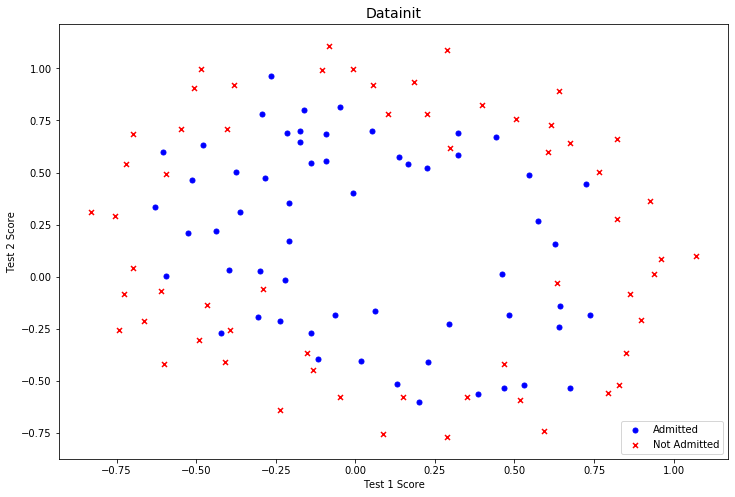

In [50]:
positive2 = data2[data2['Accepted'].isin([1])]          # 将Admitted为1(即录取)的提取出来
negative2 = data2[data2['Accepted'].isin([0])]          # 将Admitted为0(即未录取)的提取出来
# print('查看positive',positive)
# print('查看negative',negative)
fig, ax = plt.subplots(figsize=(12,8))                                   # 设置图片尺寸
ax.scatter(positive2['Test 1'], positive2['Test 2'],
           s = 25,c = 'b',marker = 'o',label = 'Admitted')              # 绘制positive的图像，s表示点的尺寸
ax.scatter(negative2['Test 1'], negative2['Test 2'],
           s = 25,c = 'r',marker = 'x',label = 'Not Admitted')          # 绘制negative的图像
ax.set_title("Datainit", fontsize=14)                                   # 图名字，字号14
ax.set_xlabel("Test 1 Score", fontsize=10)                              # x轴标签，字号10
ax.set_ylabel("Test 2 Score", fontsize=10)                              # y轴标签，字号10
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)
ax.legend(loc='lower right')
plt.show()


以上图片显示，这个数据集不能像之前一样使用直线将两部分分割。而逻辑回归只适用于线性的分割，所以，这个数据集不适合直接使用逻辑回归。

### 特征映射(features reflect)

一种更好的使用数据集的方式是为每组数据创造更多的特征。所以我们为每组x1,x2添加了最高到6次幂的特征

In [51]:
degree = 6
x1 = data2['Test 1']
x2 = data2['Test 2']
data2.insert(3, 'Ones', 1)

for i in range(1, degree+1):
    for j in range(0, i+1):
        data2['F' + str(i-j) + str(j)] = np.power(x1, i-j) * np.power(x2, j)


data2.drop('Test 1', axis=1, inplace=True)
data2.drop('Test 2', axis=1, inplace=True)

data2.head()


,Accepted,Ones,F10,F01,F20,F11,F02,F30,F21,F12,...,F23,F14,F05,F60,F51,F42,F33,F24,F15,F06
0,1,1,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,...,0.000900,0.012278,0.167542,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589,0.117206
1,1,1,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,...,0.002764,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256
2,1,1,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,...,0.015151,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047
3,1,1,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,...,0.017810,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040
4,1,1,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,...,0.026596,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193


In [61]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

### regularization -- cost function and gradient function

In [70]:
def costf(theta,X,y,lr):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    first = np.multiply(-y,np.log(sigmoid(X*theta.T)))
    second = np.multiply((1-y),np.log(1-sigmoid(X*theta.T)))
    # regularization  
    reg = (lr/ (2*len(X))) * np.sum(np.power(theta[:,1:theta.shape[1]],2))
    return np.sum(first - second)/len(X) +reg 

def gradientf(theta,X,y,lr):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X*theta.T)-y
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        
        if (i==0):
            grad[i] = np.sum(term)/len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((lr / len(X)) * theta[:,i])
    
    return grad

In [71]:
# 初始化 X，y, theta

cols = data2.shape[1]
X2 = data2.iloc[:,1:cols]  # 选取第二列到最后一列
y2 = data2.iloc[:,0:1]  # 选取第一列
theta2 = np.zeros(cols-1) # theta = 0

# 进行类型转换
X2 = np.array(X2.values)
y2 = np.array(y2.values)

# λ设为1
lr = 1

In [72]:
# compute initial cost function
costf(theta2,X2,y2,lr)


0.6931471805599454

### 用工具库求解参数

In [73]:
import scipy.optimize as opt

In [79]:
result2 = opt.fmin_tnc(func=costf, x0=theta2, fprime=gradientf, args=(X2,y2,lr))
result2


(array([ 1.27271027,  0.62529965,  1.18111686, -2.01987399, -0.91743189,
        -1.43166929,  0.12393227, -0.36553118, -0.35725403, -0.17516292,
        -1.4581701 , -0.05098418, -0.61558554, -0.27469165, -1.19271298,
        -0.2421784 , -0.20603299, -0.04466178, -0.2777895 , -0.29539514,
        -0.45645981, -1.04319154,  0.02779373, -0.2924487 ,  0.0155576 ,
        -0.32742405, -0.1438915 , -0.92467487]),
 32,
 1)

In [83]:
def predict(theta, X):
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]


In [88]:
theta_min = np.matrix(result2[0])

predictions = predict(theta_min, X2)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y2)]
accuracy = (sum(map(int, correct)) % len(correct))
print ('accuracy = {0}%'.format(accuracy))

accuracy = 98%


### 画出 决策曲线

In [89]:
def hfunc2(theta, x1, x2):
    temp = theta[0][0]
    place = 0
    for i in range(1, degree+1):
        for j in range(0, i+1):
            temp += np.power(x1, i-j) * np.power(x2, j) * theta[0][place+1]
            place+=1
    return temp

In [91]:
def find_decision_boundary(theta):
    t1 = np.linspace(-1, 1.5, 1000)
    t2 = np.linspace(-1, 1.5, 1000)
    
    cordinates = [(x,y) for x in t1 for y in t2]
    x_cord, y_cord = zip(*cordinates)
    h_val = pd.DataFrame({'x1':x_cord,'x2':y_cord})
    h_val['hval'] = hfunc2(theta,h_val['x1'],h_val['x2'])
    
    decision = h_val[np.abs(h_val['hval']) < 2 * 10**-3]
    return decision.x1, decision.x2
    

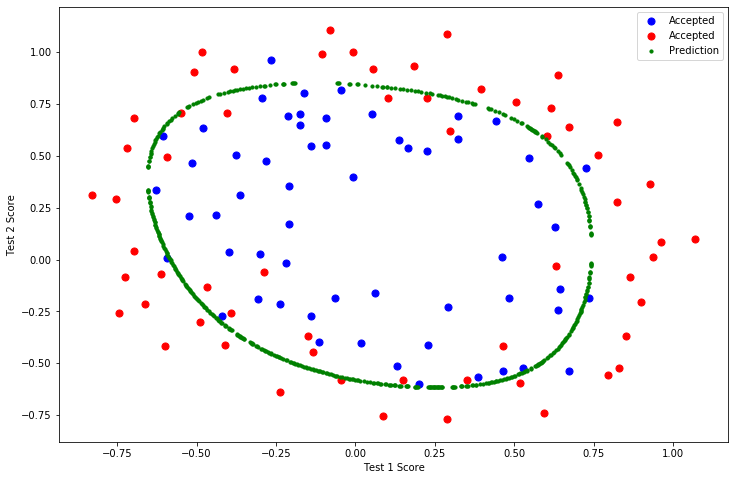

In [100]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive2['Test 1'],positive2['Test 2'],s=50,c='b',marker='o',label='Accepted')
ax.scatter(negative2['Test 1'],negative2['Test 2'],s=50,c='r',marker='o',label='Accepted')
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')

x,y = find_decision_boundary(result2)
plt.scatter(x,y,c='g',s=10,label="Prediction")  # 近似符合 theta.T*X=0的边界点
ax.legend()
plt.show()


###  改变λ，观察决策曲线
#### λ=0,过拟合

In [95]:
learningRate2 = 0
result3 = opt.fmin_tnc(func=costf, x0=theta2, fprime=gradientf, args=(X2, y2, learningRate2))
result3

(array([  12.58646447,   16.48595482,    5.14840362, -121.59636919,
         -62.12512682,  -57.14739724, -126.40787747,  -87.71674334,
         -38.11347909,    9.30236506,  419.54530932,  343.96538502,
         494.44523203,  207.10703138,   83.17813881,  223.37494017,
         288.3238265 ,  307.9208357 ,  108.92398386,   -3.89666651,
         -21.49788205, -489.06421077, -591.20615576, -902.32329953,
        -588.35375123, -561.7874465 , -194.00396998,  -39.98207113]),
 280,
 3)

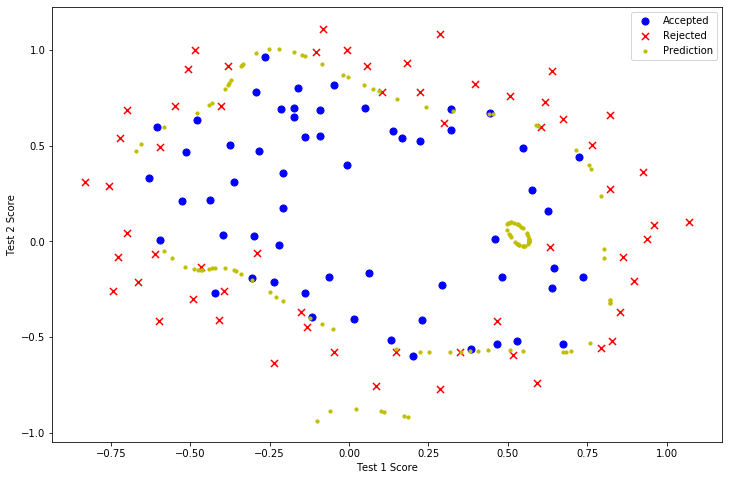

In [96]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive2['Test 1'], positive2['Test 2'], s=50, c='b', marker='o', label='Accepted')
ax.scatter(negative2['Test 1'], negative2['Test 2'], s=50, c='r', marker='x', label='Rejected')
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')

x, y = find_decision_boundary(result4)
plt.scatter(x, y, c='y', s=10, label='Prediction')
ax.legend()
plt.show()

#### λ=100 欠拟合

In [98]:
learningRate3 = 100
result4 = opt.fmin_tnc(func=costf, x0=theta2, fprime=gradientf, args=(X2, y2, learningRate3))

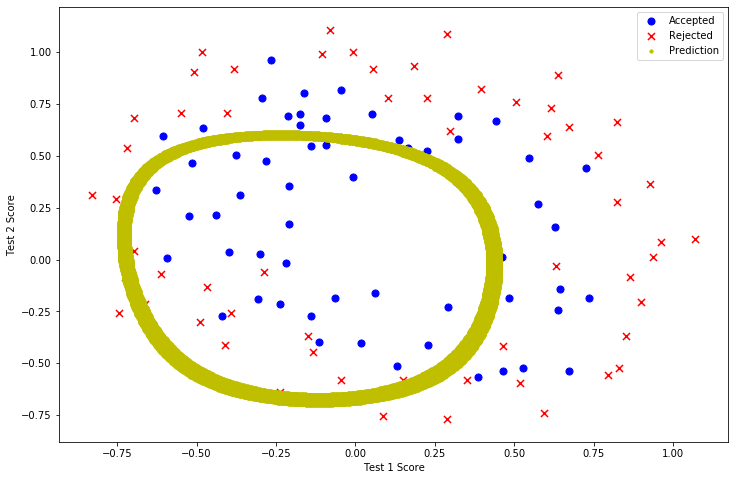

In [99]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive2['Test 1'], positive2['Test 2'], s=50, c='b', marker='o', label='Accepted')
ax.scatter(negative2['Test 1'], negative2['Test 2'], s=50, c='r', marker='x', label='Rejected')
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')

x, y = find_decision_boundary(result4)
plt.scatter(x, y, c='y', s=10, label='Prediction')
ax.legend()
plt.show()